In [1]:
import scipy
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import pickle
import math

In [2]:
fDF = pd.read_csv('Data/featureTypes.txt', names=['featureID'])

In [3]:
print fDF.shape
print fDF['featureID'][0]
n = 10000
d = 3000

(3000, 1)
flavors raspberries cherries


In [4]:
trainDF = pd.read_csv('Data/trainData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
YDF = pd.read_csv('Data/trainLabels.txt', names = ['label'])
valXDF = pd.read_csv('Data/valData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
valYDF = pd.read_csv('Data/valLabels.txt', names = ['label'])
print trainDF.shape[0]

247847


In [5]:
W = np.random.rand(d)  #random.uniform(low=0.0, high=1.0,size = (d,))
B = 0 #np.zeros(n)
TempBArray = np.ones(n)
print W.shape
#print TempBArray
print np.count_nonzero(W)
print len(W)
print W

(3000,)
3000
3000
[ 0.78260863  0.27778095  0.79673808 ...,  0.78413721  0.97773137
  0.33856023]


In [6]:
trainDF[:5]

,instanceID,featureID,value
0,1,13,0.209
1,1,83,0.209
2,1,228,0.209
3,1,242,0.209
4,1,371,0.209


In [7]:
#tDF = csr_matrix(trainDF) 
#print tDF[:5]

In [8]:
#sdf = pd.SparseDataFrame(tDF)
#print sdf[:5]

In [9]:
# Will lead to negative index if re-running
trainDF['instanceID'] -= 1
trainDF['featureID'] -= 1
sMat = csr_matrix((trainDF['value'], (trainDF['featureID'], trainDF['instanceID'])))
valXDF['instanceID'] -= 1
valXDF['featureID'] -= 1
valX = csr_matrix((valXDF['value'], (valXDF['featureID'], valXDF['instanceID'])))
Y = YDF['label'].as_matrix().transpose()
#print Y.shape
valY = valYDF['label'].as_matrix().transpose()

In [10]:
#print sMat.shape
#print sMat.todense()
print sMat.max(), sMat.min()

0.728 0.0


In [11]:
#print sMat[:2]

In [12]:
X = sMat.copy()
print X.shape

(3000, 10000)


In [13]:
print len(W.nonzero())
print len(W)

1
3000


In [14]:
def initLamda(X, Y):
    YNorm = Y - float(Y.sum())/((float)(Y.shape[0]))
    return 2 * (abs(X * YNorm).max())
    
print initLamda(X, Y)

1271.869651


In [15]:
t = X.copy()
t.data **= 2
At = 2*t.sum(axis = 1)
print At

[[ 0.731852]
 [ 2.660682]
 [ 1.581472]
 ..., 
 [ 1.564942]
 [ 2.31796 ]
 [ 1.5809  ]]


In [16]:
redFact = 0.000002

In [17]:
# change this to convergence condition

def rmse(input1, input2):
    out = input1 - input2
    #print out
    out **= 2
    out /= len(out)
    error = out.sum()
    return math.sqrt(error)


class Lasso:
    def __init__(self, X, Y, W, B, Lamda):
        self.X = X.copy()
        self.Y = Y.copy()
        self.W = W #.copy()  # Remove this copy later
        self.B = B #.copy()
        t = X.copy()
        t.data **= 2
        self.A = 2*t.sum(axis = 1)
        self.Lamda = Lamda
        self.delta = 0.01
        # Stores Lamda and respective RMSE
        self.trainrmse = []
        self.trainlamda = []
        self.valrmse = []
        self.vallamda = []
        self.NonZero = []
        
    def loss(self):
        return ((self.X.transpose() * self.W + self.B - self.Y) ** 2).sum() + self.Lamda * (abs(self.W)).sum()
        
    def fit(self):
        # Lamda = initLamda(self.X, self.Y)
        oldLoss = self.loss()+2
        newLoss = self.loss()
        print 'Lamda: ', self.Lamda
        while oldLoss - newLoss > self.delta:
            XTW = (self.X.transpose() * self.W)
            R = self.Y - (self.X.transpose() * self.W) - self.B
            # 4.1.2
            BOld = self.B
            self.B = np.full(n, (R + self.B).sum() / n) 
            # 4.1.3
            R =  R + BOld - self.B
            for ik in range(0, d):
                # 4.1.4
                t = (self.X[ik].transpose() * self.W[ik]).toarray().reshape(-1)
                Ck = 2*( self.X[ik] * (R + t)).sum()
                #print 'CK:', Ck
                WkOld = self.W[ik]
                #print 'OW: ', WkOld
                if Ck < -self.Lamda:
                    self.W[ik] = (Ck + self.Lamda) / self.A[ik]
                elif Ck > self.Lamda:
                    self.W[ik] = (Ck - self.Lamda) / self.A[ik]
                else:
                    self.W[ik] = 0
                # 4.1.5
                R = R + self.X[ik].toarray().reshape(-1) * (WkOld - self.W[ik])
            oldLoss = newLoss
            newLoss = model.loss()
            print 'LOSS:' , newLoss
            # End of feature vector iterator
    
    def saveModel(self, filename):
        pickle.dump(self, open( filename, "wb" ))
    
    def predict(self, X):
        return (X.transpose() * self.W + np.full(X.transpose().shape[0], self.B))
    
    def chooseCorrectLamda(self, delta = -1):
        oldLamda = self.Lamda
        if delta != -1:
            self.delta = delta
        self.fit()
        
        newRMSE = rmse(self.predict(self.X), self.Y)
        self.trainrmse.append(newRMSE)
        self.trainlamda.append(self.Lamda)
        valRMSE = rmse(self.predict(valX), valY)
        self.valrmse.append(valRMSE)
        self.vallamda.append(self.Lamda)
        oldRMSE = valRMSE
        self.NonZero.append((self.W != 0.0).sum())
        print 'Lamda: ', self.Lamda, 'RMSE: ', newRMSE, 'Val RMSE:' , valRMSE
        
        while oldRMSE >= valRMSE:
            oldLamda = self.Lamda
            self.Lamda /= 2
            self.fit()
            oldRMSE = valRMSE
            #self.TrainInfo.append([self.Lamda, newRMSE])
            newRMSE = rmse(self.predict(self.X), self.Y)
            self.trainrmse.append(newRMSE)
            self.trainlamda.append(self.Lamda)
            valRMSE = rmse(self.predict(valX), valY)
            #self.ValInfo.append([self.Lamda, valRMSE])
            self.valrmse.append(valRMSE)
            self.vallamda.append(self.Lamda)
            self.NonZero.append(np.count_nonzero(self.W))
            #self.NonZero.append(self.W.toarray().count_nonzero())
            print 'Lamda: ', self.Lamda, 'RMSE: ', newRMSE, 'Val RMSE:' , valRMSE
            self.saveModel('optimal_saved_Model')
    
def loadModel(filename):
    return pickle.load(open(filename, "rb" ))

In [18]:
model = Lasso(X, Y, W, B,initLamda(X.copy(), Y.copy()))
#model.loss()
#model.fit()

In [19]:
print model.Lamda

1271.869651


In [20]:
#model.Lamda = 2.48
model.chooseCorrectLamda()

Lamda:  1271.869651
LOSS: 157337.499665
LOSS: 126515.833828
LOSS: 116006.711277
LOSS: 115339.9759
LOSS: 115339.9759
Lamda:  1271.869651 RMSE:  3.39617396345 Val RMSE: 3.38958619451
Lamda:  635.9348255
LOSS: 113464.97052
LOSS: 113351.724815
LOSS: 113268.054226
LOSS: 113230.355473
LOSS: 113218.396063
LOSS: 113214.759373
LOSS: 113213.598487
LOSS: 113213.216459
LOSS: 113213.088791
LOSS: 113213.045865
LOSS: 113213.031406
LOSS: 113213.026535
Lamda:  635.9348255 RMSE:  3.23821259074 Val RMSE: 3.24104460255
Lamda:  317.96741275
LOSS: 104744.941446
LOSS: 104554.42193
LOSS: 104545.387955
LOSS: 104541.882211
LOSS: 104540.428196
LOSS: 104539.82136
LOSS: 104539.565546
LOSS: 104539.456195
LOSS: 104539.408699
LOSS: 104539.387787
LOSS: 104539.378498
Lamda:  317.96741275 RMSE:  2.98747257489 Val RMSE: 3.00146097787
Lamda:  158.983706375
LOSS: 93412.4890774
LOSS: 93143.1853589
LOSS: 93116.7032316
LOSS: 93094.8117959
LOSS: 93076.9067196
LOSS: 93064.2729722
LOSS: 93056.4820827
LOSS: 93052.1603386
LOSS: 93

LOSS: 39655.9720533
LOSS: 39655.9384635
LOSS: 39655.9070806
LOSS: 39655.8777857
LOSS: 39655.8504492
LOSS: 39655.8249429
LOSS: 39655.8011448
LOSS: 39655.7789411
LOSS: 39655.7582267
LOSS: 39655.7389045
LOSS: 39655.7208852
LOSS: 39655.7040858
LOSS: 39655.6884292
LOSS: 39655.6738432
LOSS: 39655.6602599
LOSS: 39655.647615
LOSS: 39655.635848
LOSS: 39655.6249012
LOSS: 39655.6147199
LOSS: 39655.6052526
Lamda:  4.96824082422 RMSE:  1.70582680523 Val RMSE: 1.9667089591
Lamda:  2.48412041211
LOSS: 33445.7938666
LOSS: 33310.2533594
LOSS: 33281.6885089
LOSS: 33270.8462574
LOSS: 33265.0470989
LOSS: 33260.7760764
LOSS: 33257.0006701
LOSS: 33253.4603507
LOSS: 33249.8756387
LOSS: 33246.1953835
LOSS: 33242.4164402
LOSS: 33238.5703228
LOSS: 33234.7123126
LOSS: 33230.8891764
LOSS: 33227.1079371
LOSS: 33223.3964749
LOSS: 33219.7833471
LOSS: 33216.284477
LOSS: 33212.9109058
LOSS: 33209.6695891
LOSS: 33206.5651484
LOSS: 33203.602986
LOSS: 33200.7853067
LOSS: 33198.1116133
LOSS: 33195.581656
LOSS: 33193.18809

In [22]:
model.saveModel('model2826')
#model.Lamda = 2.2
#model.chooseCorrectLamda()

In [25]:
model.saveModel('model2826_1.94663989568')

In [26]:
model.Lamda = 2.83
model.chooseCorrectLamda()

Lamda:  2.83
LOSS: 34246.271538
LOSS: 34246.2704434
LOSS: 34246.2697656
Lamda:  2.83 RMSE:  1.5999541841 Val RMSE: 1.94662633765
Lamda:  2.828
LOSS: 34240.1568702
LOSS: 34240.1562082
Lamda:  2.828 RMSE:  1.59986040365 Val RMSE: 1.9466252775
Lamda:  2.826
LOSS: 34234.0410832
LOSS: 34234.0403814
Lamda:  2.826 RMSE:  1.59975724008 Val RMSE: 1.94662784398


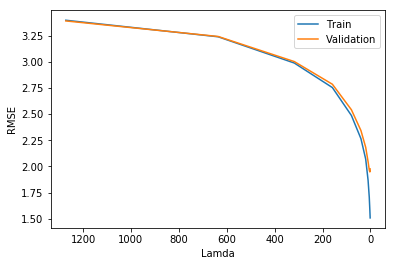

In [20]:
import matplotlib.pyplot as plt
plt.plot(model.trainlamda, model.trainrmse)
plt.plot(model.vallamda, model.valrmse)
plt.ylabel('RMSE')
plt.xlabel('Lamda')
ax = plt.gca()
ax.invert_xaxis()
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('RMSEvsLamda.png')

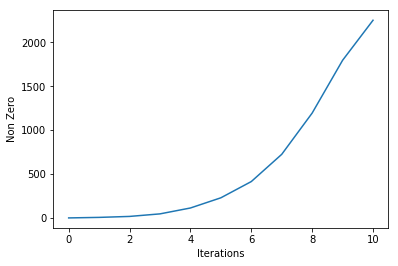

[0, 6, 17, 46, 113, 229, 414, 724, 1194, 1795, 2251]
2251


In [24]:
import matplotlib.pyplot as plt
plt.plot(model.NonZero)
plt.ylabel('Non Zero')
plt.xlabel('Iterations')
#plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print model.NonZero
print np.count_nonzero(model.W)
#plt.savefig('NonZeroElements.png')

In [21]:
model.saveModel('savedModel244')

In [22]:
#print model.lamda
print rmse(model.predict(valX), valY)
print rmse(X.transpose() * model.W, valY)
print model.predict(valX)
print valY

1.94746234814
82.9623798309
[ 91.4244674   92.86989377  87.52762187 ...,  91.66197947  88.13588147
  91.14908862]
[92 90 86 ..., 92 89 88]


In [28]:
testXDF = pd.read_csv('Data/testData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
testX = csr_matrix((valXDF['value'], (valXDF['featureID'], valXDF['instanceID'])))
testPredicted = model.predict(testX)
print testPredicted
np.savetxt("out3.csv", testPredicted, delimiter=",")
#testPredicted.to_csv('out.csv')

[ 105.71206656   85.54415933   87.60385796 ...,   87.82942353   87.01643808
   85.78716094]


In [ ]:
# Mixture
bigData = (X + valX) / 2


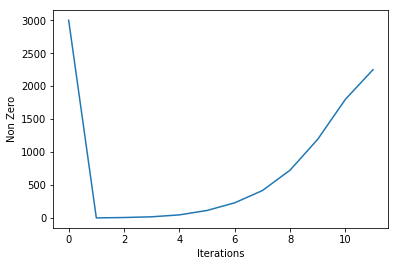

In [56]:
loadedModel = loadModel('./finalData/savedModel')
plt.plot(loadedModel.NonZero)
plt.ylabel('Non Zero')
plt.xlabel('Iterations')
plt.show()

In [71]:
print loadedModel.W
WLoaded = list(loadedModel.W)
sorted(range(len(WLoaded)), key=lambda i: WLoaded[i])[-10:]
print WLoaded[2468]
print max(WLoaded)

[ 0.          3.70430265  5.27646819 ..., -0.17621468  0.91925534
  1.82692104]
8.76831112942
11.2180665852


In [52]:
#print loadedModel.trainlamda[1:]
#print loadedModel.trainrmse.shape
#plt.plot(loadedModel.trainlamda[1:], loadedModel.trainrmse)
##plt.plot(loadedModel.vallamda[1:], loadedModel.valrmse)
##plt.ylabel('RMSE')
#plt.xlabel('Lamda')
#ax = plt.gca()
#ax.invert_xaxis()
#plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()

In [23]:
valModel = Lasso(valX, valY, W, B, model.Lamda)


In [29]:
valModel.Lamda = 2.4466

valModel.fit()

Lamda:  2.4466
LOSS: 46061.9208606


In [30]:
#print model.lamda
print rmse(model.predict(valX), valY)
print rmse(X.transpose() * model.W, valY)
print model.predict(valX)
print valY
print rmse(valY, (valModel.X.transpose() * valModel.W) + np.full(valModel.X.transpose().shape[0], valModel.B[0]))
print rmse(Y, (X.transpose() * valModel.W) + np.full(X.transpose().shape[0], valModel.B[0]))


1.57783036912
82.9929263079
[ 92.32272427  91.22622797  86.10513532 ...,  91.78557323  87.37710008
  88.78861758]
[92 90 86 ..., 92 89 88]
1.57779314644
1.93942737706


In [116]:
#print model.lamda
print rmse(model.predict(valX), valY)
print rmse(X.transpose() * model.W, valY)
print model.predict(valX)
print valY
print rmse(valY, (valModel.X.transpose() * valModel.W) + np.full(valModel.X.transpose().shape[0], valModel.B[0]))
print rmse(Y, (X.transpose() * valModel.W) + np.full(X.transpose().shape[0], valModel.B[0]))


2.3258676229
81.1925424054
[ 93.95461517  92.93189006  87.62378878 ...,  92.54065589  89.5128428
  89.97589808]
[92 90 86 ..., 92 89 88]
1.46293862824
2.0969385907


In [31]:
testXDF = pd.read_csv('Data/testData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
testXDF['instanceID'] -= 1
testXDF['featureID'] -= 1
testX = csr_matrix((testXDF['value'], (testXDF['featureID'], testXDF['instanceID'])))
print testX.shape[0]
testPredicted = (testX.transpose() * valModel.W) + np.full(testX.transpose().shape[0], valModel.B[0])
#np.full(X.transpose().shape[0], self.B)
#testPredicted = valModel.predict(testX)
print testPredicted
np.savetxt("out3.csv", testPredicted, delimiter=",", )

3000
[ 90.64266457  82.70100871  88.68079993 ...,  88.03124281  87.9261721
  87.17292611]
